In [2]:
%load_ext autoreload
%autoreload 2

import itertools
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool
import time
from tqdm import tqdm

from graph_generation import GenerateGraph
from models import GCN
from train import Trainer, Dataset
from embedding import Embedding
from experiments import train_take_embedding, plot_dim1, plot_dimN, plot_correlation_error, get_metrics
from config_valid import Config, TrainingMode
from plot_model import plot_model
from utils import plot_wo_outliers

import torch
from torch_geometric.loader import DataLoader
device = torch.device('cuda')

from plt_parameters import init_params
init_params()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

# Regressione

## Distribuzione discreta - ultimo layer Denso

In [14]:
config_file = "configurations/regression1.yml"
config_c = Config(config_file)
gg = GenerateGraph(config_c)
dataset = gg.initialize_dataset()

Generating dataset...
Mean connectivity for each node: 14.978 p=0.05
Mean connectivity for each node: 89.709 p=0.3
Dataset generated


In [15]:
graph_embeddings_array, node_embeddings_array, model, test_loss_list, trainer = train_take_embedding(config_c, dataset, verbose=False)

Initialize model
Loading Dataset...


100%|████████████████████████████████████████████████████████████████| 600/600 [00:40<00:00, 14.81it/s]


Tempo impiegato: 40.593814849853516
Before training Test loss: 0.00022396636712882254
Run training for 1800 epochs
Epoch: 1799	Test loss: 1.3180231002883779e-05 		 FINE TRAINING


### Display the model

aten::new_zeros %index.13 : Long(45000, strides=[1], requires_grad=0, device=cuda:0) = aten::new_zeros(%519, %387, %388, %389, %390, %391) # /home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/torch_geometric/nn/aggr/base.py:56:0



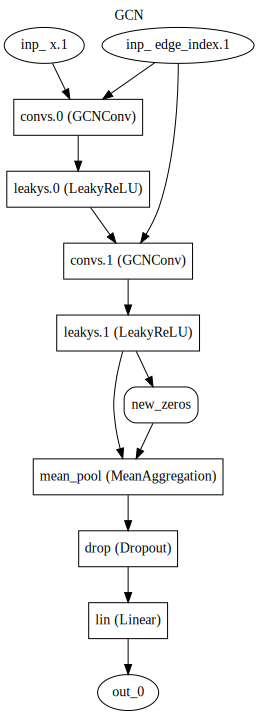

In [6]:
batch = trainer.dataset.sample_dummy_data()
d = plot_model(trainer.model, batch)
d

### Inspect Embedding feature arrays

In [23]:
embeddings = Embedding(graph_embeddings_array, trainer.dataset, test_loss_list, config_c)

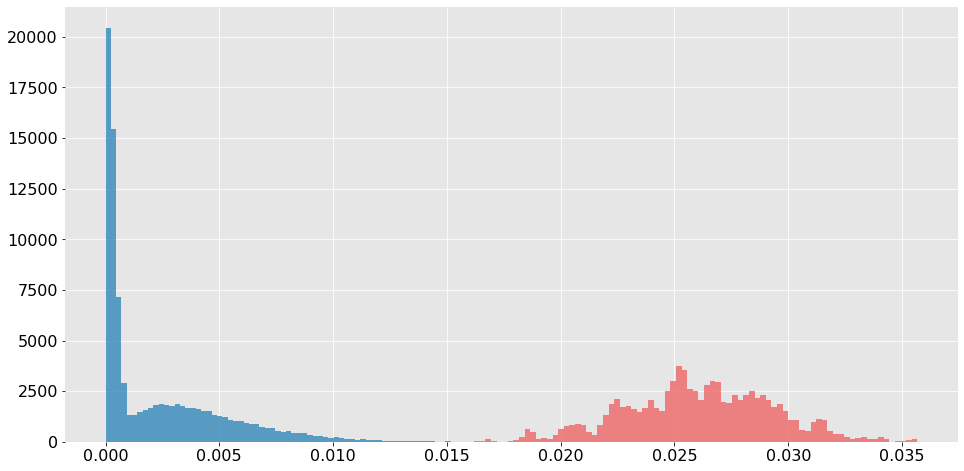

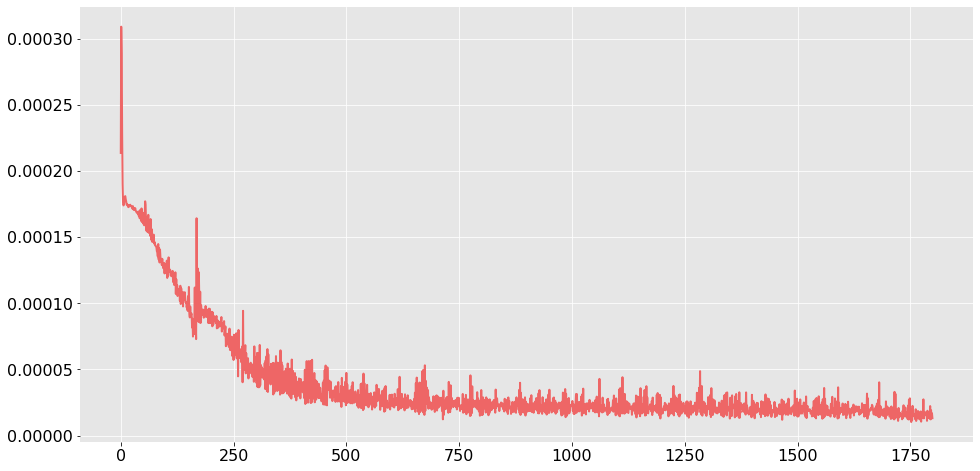

In [24]:
num_emb_neurons = trainer.model.convs[-1].out_channels
get_metrics(embeddings, num_emb_neurons)
plt.plot(test_loss_list);

## Distribuzione discreta - senza ultimo layer Denso

In [25]:
config_file = "configurations/regression2.yml"
config_c = Config(config_file)
gg = GenerateGraph(config_c)
dataset = gg.initialize_dataset()
graph_embeddings_array, node_embeddings_array, model, test_loss_list, trainer = train_take_embedding(config_c, dataset, verbose=False)

Generating dataset...
Mean connectivity for each node: 14.973 p=0.05
Mean connectivity for each node: 89.673 p=0.3
Dataset generated
Initialize model
Loading Dataset...


100%|████████████████████████████████████████████████████████████████| 600/600 [00:40<00:00, 14.74it/s]


Tempo impiegato: 40.791261434555054
Before training Test loss: 0.0006073943649729092
Run training for 800 epochs
Epoch: 799	Test loss: 3.7214253097772597e-06 		 FINE TRAINING


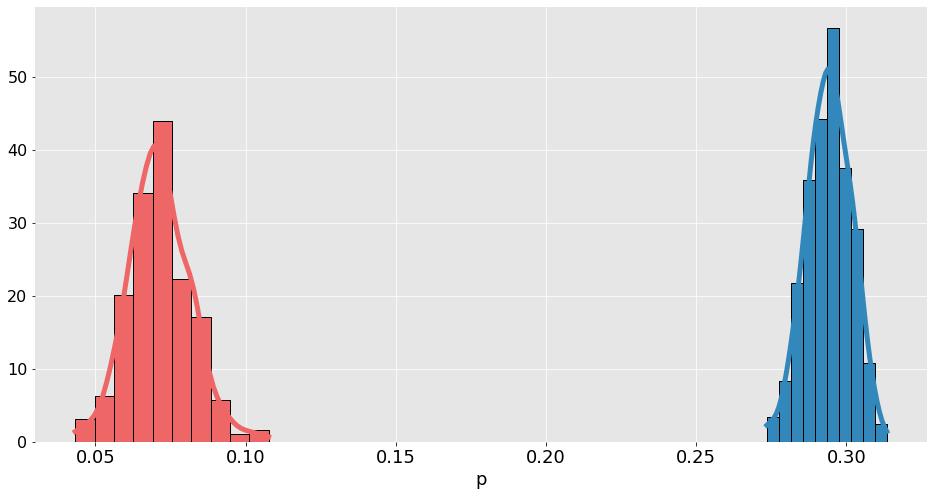

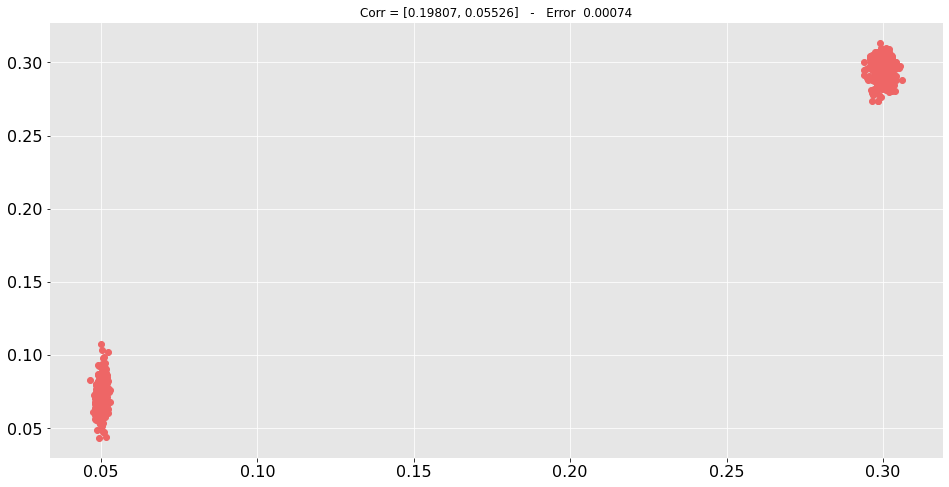

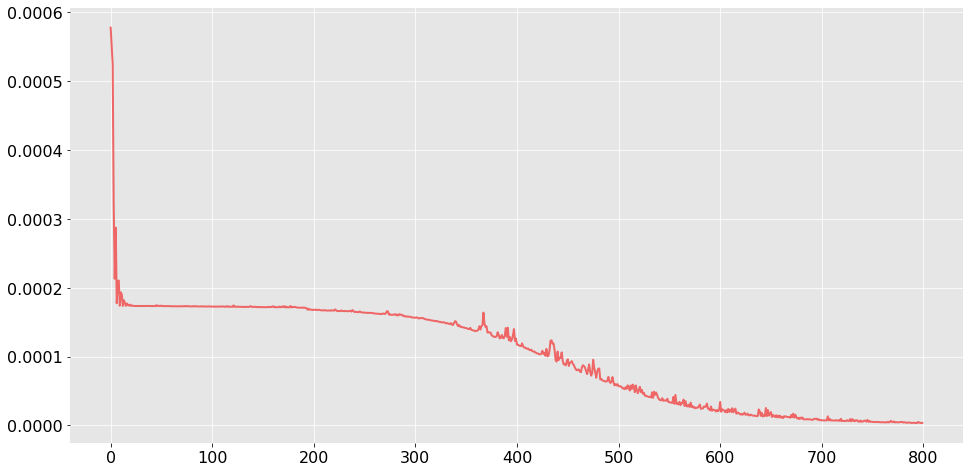

In [28]:
embeddings = Embedding(graph_embeddings_array, trainer.dataset, test_loss_list, config_c)
num_emb_neurons = trainer.model.convs[-1].out_channels
get_metrics(embeddings, num_emb_neurons)
plt.plot(test_loss_list);

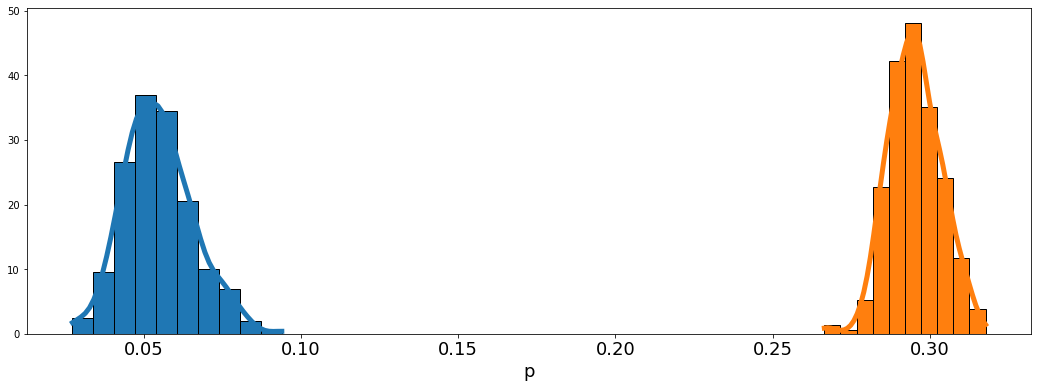

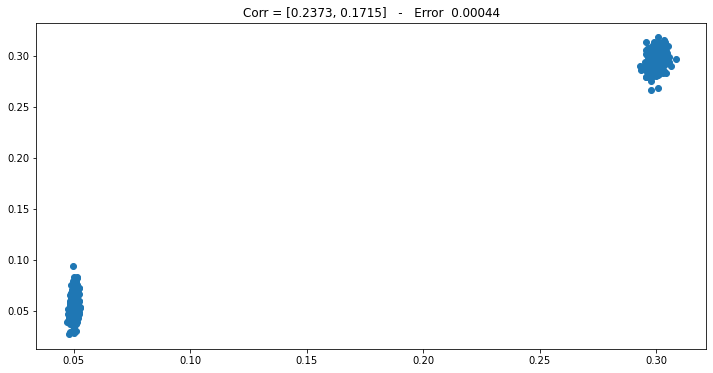

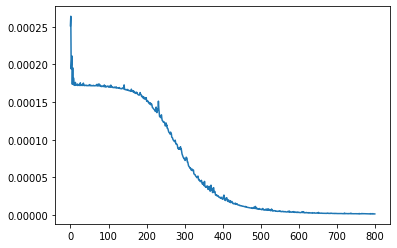

In [ ]:
provare con più di due classi, far vedere che quando aggiungo le classi come vanno i picchi

## Distribuzione continua - ultimo layer Denso

In [29]:
config_file = "configurations/regression3.yml"
dataset, config_c = initialize_dataset(config_file)

Generating dataset...
Dataset generated


In [30]:
embeddings_array, model, test_loss_list, trainer = train_take_embedding(config_c, dataset, type_embedding='graph')

GCN(
  (convs): ModuleList(
    (0): GCNConv(1, 16)
    (1): GCNConv(16, 8)
  )
  (lin): Linear(in_features=8, out_features=1, bias=True)
  (leakys): ModuleList(
    (0): LeakyReLU(negative_slope=0.03)
    (1): LeakyReLU(negative_slope=0.03)
    (2): LeakyReLU(negative_slope=0.03)
  )
  (mean_pool): MeanAggregation()
  (drop): Dropout(p=0.5, inplace=False)
)
MSELoss()
Loading Dataset...


100%|████████████████████████████████████████████████████████████| 1000/1000 [02:06<00:00,  7.92it/s]


Tempo impiegato: 126.45102858543396
tensor([0.1292], device='cuda:0') 700
tensor([0.2165], device='cuda:0') 300
runs/lr-0.01_epochs8000_bs150_neurons-1-16-8-1_04Aug_13-55-47
Run training for 8000 epochs
Before training Test loss: 0.0036392011245091754
Epoch: 0	Test loss: 0.001661748637755712
Epoch: 100	Test loss: 0.00017089370638132095
Epoch: 200	Test loss: 0.0001709631582101186
Epoch: 300	Test loss: 0.00017090409994125367
Epoch: 400	Test loss: 0.000170857273042202
Epoch: 500	Test loss: 0.00017095836500326792
Epoch: 600	Test loss: 0.0001709594080845515
Epoch: 700	Test loss: 0.0001709339829782645
Epoch: 800	Test loss: 0.00017091457421580951
Epoch: 900	Test loss: 0.00017093848437070845
Epoch: 1000	Test loss: 0.00017104568580786388
Epoch: 1100	Test loss: 0.00017115475609898566
Epoch: 1200	Test loss: 0.00017092793559034665
Epoch: 1300	Test loss: 0.00017083444943030674
Epoch: 1400	Test loss: 0.0001343288707236449
Epoch: 1500	Test loss: 9.347592170039813e-05
Epoch: 1600	Test loss: 9.46654379

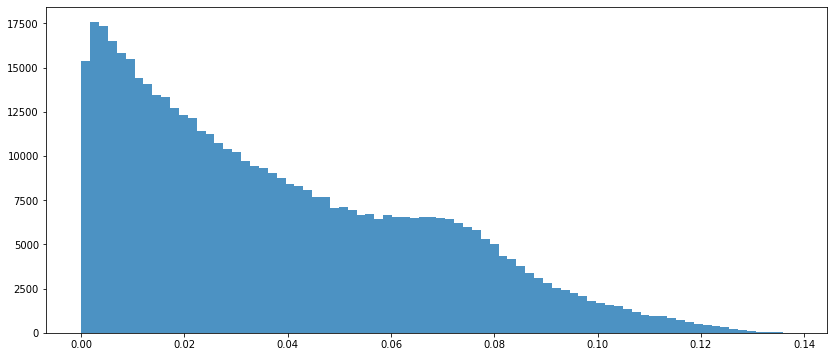

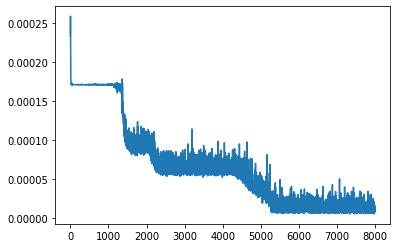

In [34]:
embeddings = Embedding(embeddings_array, trainer.dataset, test_loss_list, config_c)
num_emb_neurons = trainer.model.convs[-1].out_channels
get_metrics(embeddings, num_emb_neurons)
plt.plot(plot_wo_outliers(test_loss_list));

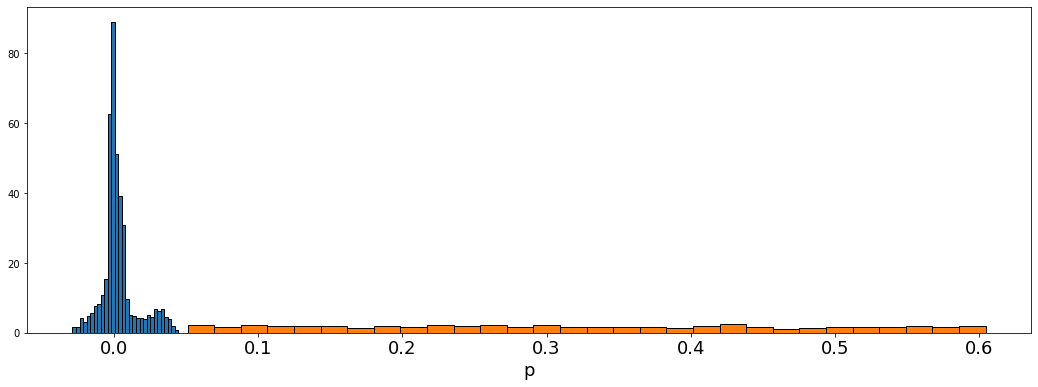

In [38]:
emb = embeddings.embeddings_array.flatten()
lab = embeddings.embedding_labels
plot_dim1([emb, lab], bins=30, want_kde=False)

## Distribuzione continua - senza ultimo layer Denso

In [33]:
config_file = "configurations/regression4.yml"
config_c = Config(config_file)
gg = GenerateGraph(config_c)
dataset = gg.initialize_dataset()
graph_embeddings_array, node_embeddings_array, model, test_loss_list, trainer = train_take_embedding(config_c, dataset, verbose=False)

Generating dataset...
Dataset generated
Initialize model
Loading Dataset...


100%|██████████████████████████████████████████████████████████████| 1000/1000 [02:02<00:00,  8.17it/s]


Tempo impiegato: 122.57704901695251
Before training Test loss: 0.00035678914437691373
Run training for 1800 epochs
Epoch: 1799	Test loss: 6.995029592265685e-06 		 FINE TRAINING


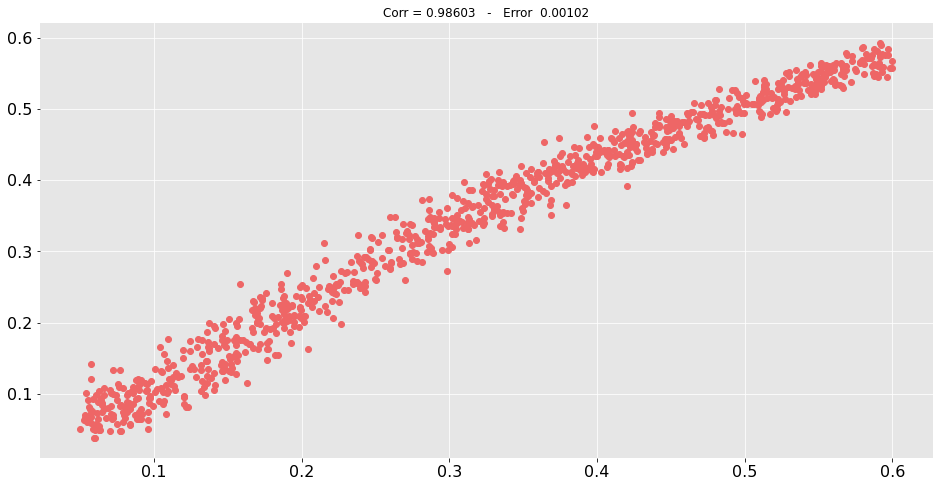

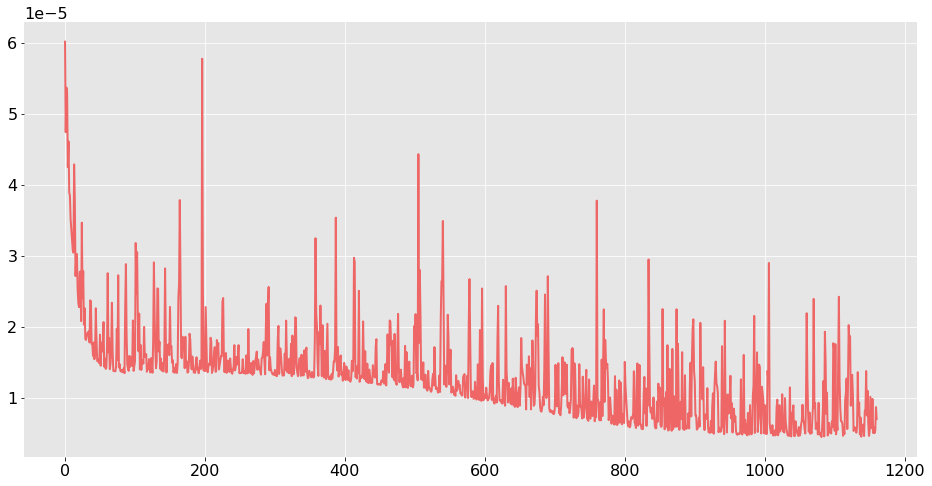

In [34]:
embeddings = Embedding(graph_embeddings_array, trainer.dataset, test_loss_list, config_c)
num_emb_neurons = trainer.model.convs[-1].out_channels
get_metrics(embeddings, num_emb_neurons)
plt.plot(plot_wo_outliers(test_loss_list));

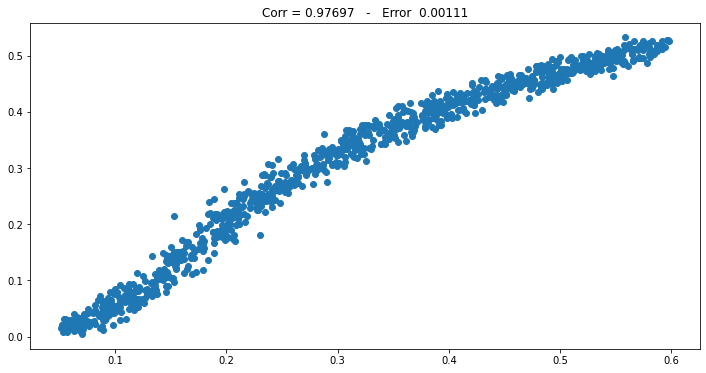

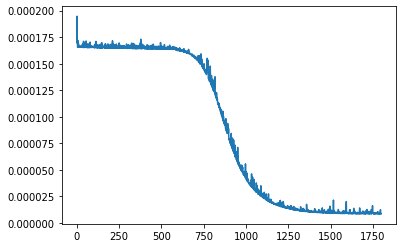

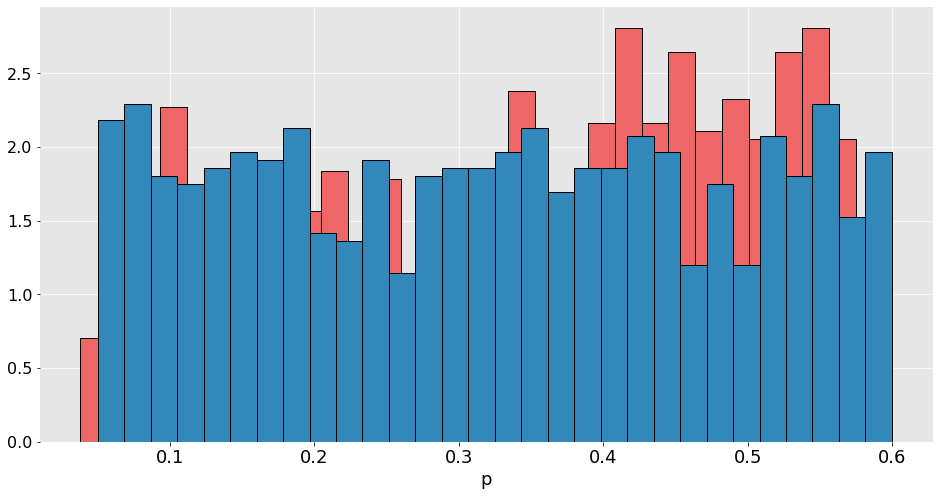

In [35]:
emb = embeddings.embeddings_array.flatten()
lab = embeddings.embedding_labels
plot_dim1([emb, lab], bins=30, want_kde=False)

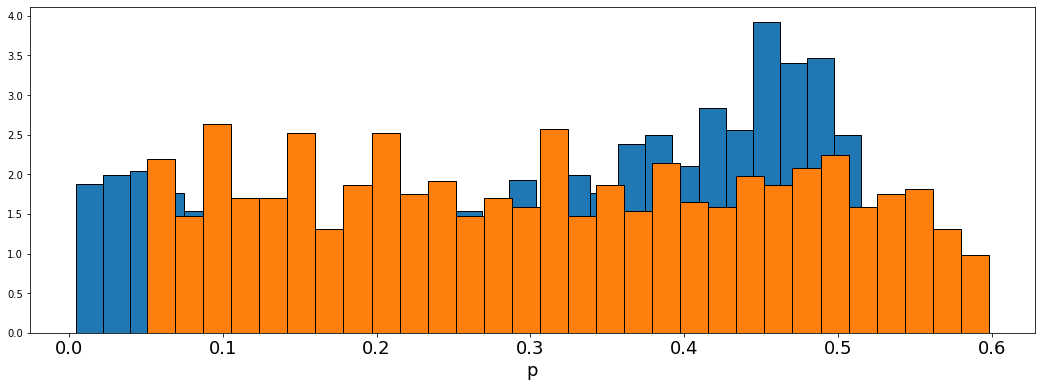

# Classificazione

## ultimo layer Denso

In [36]:
config_file = "configurations/classification1.yml"
config_c = Config(config_file)
gg = GenerateGraph(config_c)
dataset = gg.initialize_dataset()
graph_embeddings_array, node_embeddings_array, model, test_loss_list, trainer = train_take_embedding(config_c, dataset, verbose=False)

Generating dataset...
Mean connectivity for each node: 14.968 p=0.05
Mean connectivity for each node: 89.66 p=0.3
Dataset generated
Initialize model
Loading Dataset...


100%|████████████████████████████████████████████████████████████████| 600/600 [00:42<00:00, 14.27it/s]


Tempo impiegato: 42.124260663986206
Before training Test loss: 0.0077148897780312435
Run training for 2500 epochs
Epoch: 2499	Test loss: 4.659114120942023e-05 		 FINE TRAINING


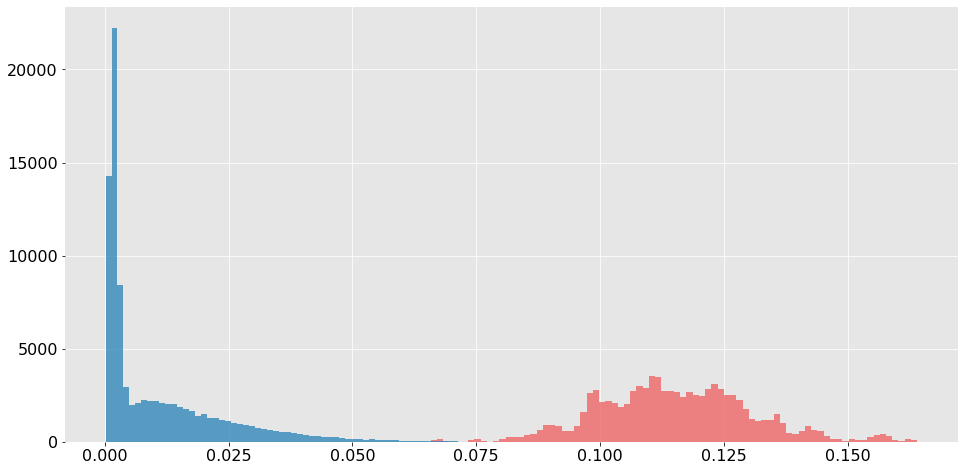

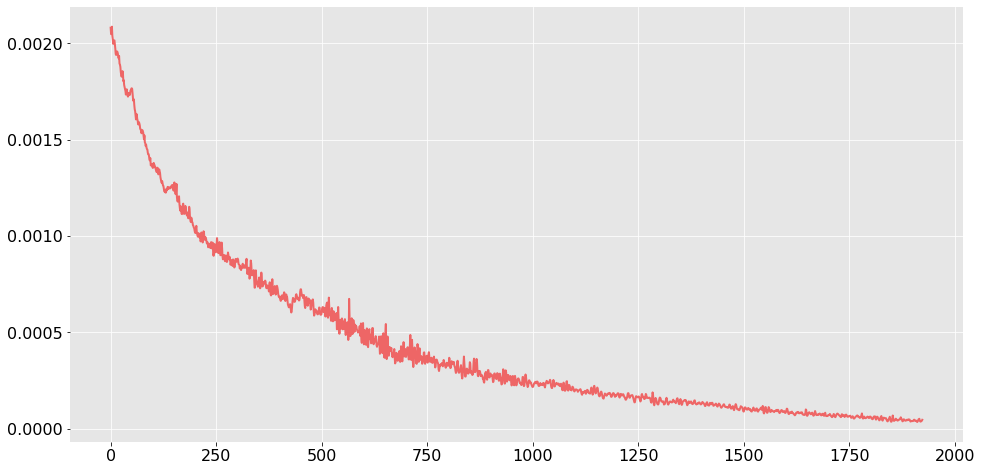

In [37]:
embeddings = Embedding(graph_embeddings_array, trainer.dataset, test_loss_list, config_c)
num_emb_neurons = trainer.model.convs[-1].out_channels
get_metrics(embeddings, num_emb_neurons)
plt.plot(plot_wo_outliers(test_loss_list));

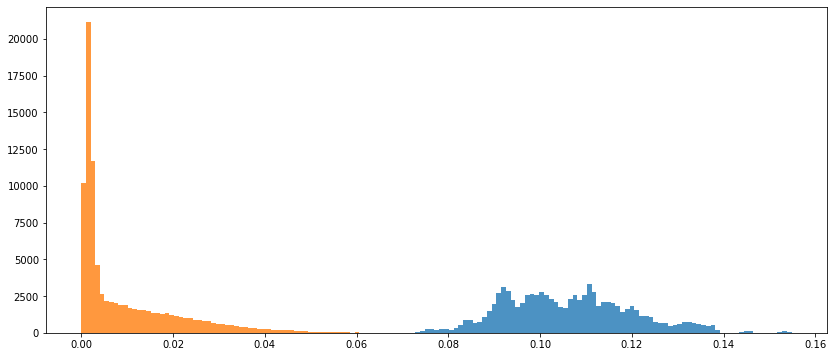

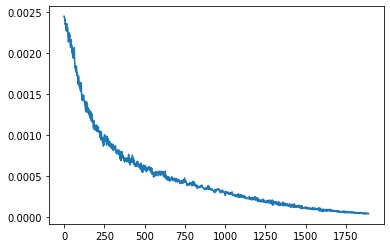

## senza ultimo layer Denso

In [38]:
config_file = "configurations/classification2.yml"
config_c = Config(config_file)
gg = GenerateGraph(config_c)
dataset = gg.initialize_dataset()
graph_embeddings_array, node_embeddings_array, model, test_loss_list, trainer = train_take_embedding(config_c, dataset, verbose=False)

Generating dataset...
Mean connectivity for each node: 14.94 p=0.05
Mean connectivity for each node: 89.743 p=0.3
Dataset generated
Initialize model
Loading Dataset...


100%|████████████████████████████████████████████████████████████████| 600/600 [00:42<00:00, 14.07it/s]


Tempo impiegato: 42.73449778556824
Before training Test loss: 0.007952163616816202
Run training for 2500 epochs
Epoch: 2499	Test loss: 1.0949554659115771e-05 		 FINE TRAINING


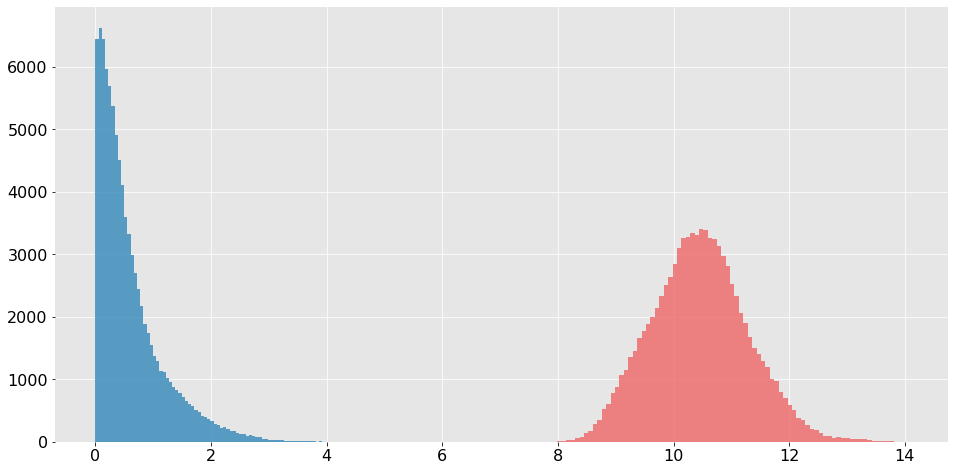

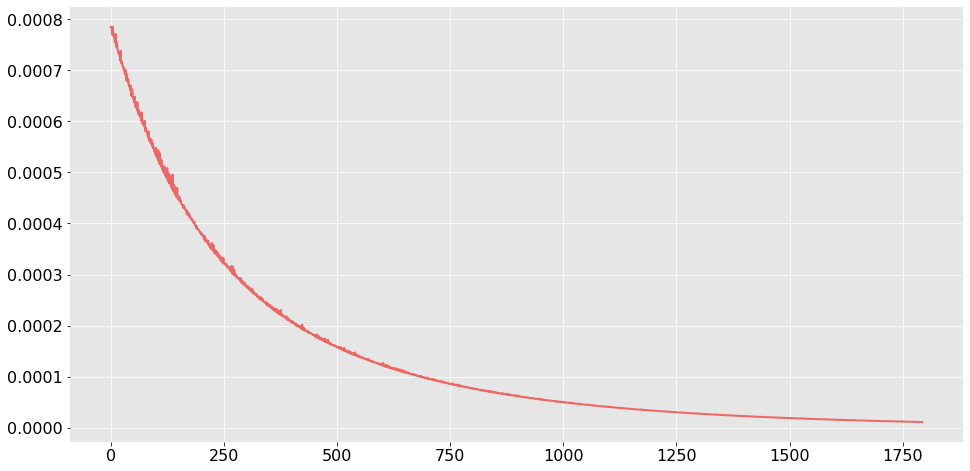

In [39]:
embeddings = Embedding(graph_embeddings_array, trainer.dataset, test_loss_list, config_c)
num_emb_neurons = trainer.model.convs[-1].out_channels
get_metrics(embeddings, num_emb_neurons)
plt.plot(plot_wo_outliers(test_loss_list));

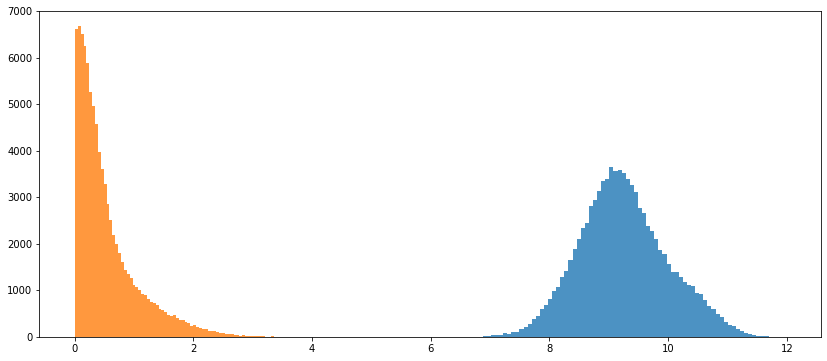

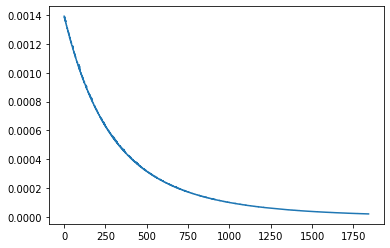

In [ ]:
anche questo con più classi

In [60]:
embeddings.embeddings_array.shape

(600, 2)

# Vedo cosa fa su altri grafi che non ha mai visto, con p diversa

In [ ]:
config['graph_dataset']['list_p'] = [0.03, 0.2]
dataset_grafi_nx, dataset_labels, list_p = dataset_nclass_ER(config)
trainer.load_dataset(dataset_grafi_nx, dataset_labels)
whole_data = trainer.dataset.dataset_pyg
all_data_loader = DataLoader(whole_data, batch_size=trainer.dataset.bs, shuffle=False) 
embeddings_array2 = trainer.take_embedding(all_data_loader)
embeddings_array2 = np.array([emb.cpu().detach().numpy() for emb in embeddings_array2])

embeddings2 = Embedding(embeddings_array2, trainer.dataset.dataset, trainer.dataset.labels, list_p)

In [ ]:
plt.figure(figsize=(18, 4))
h,e = np.histogram(embeddings2.embeddings_array.flatten(), bins=30, density=False)
x = np.linspace(e.min(), e.max())
plt.bar(e[:-1], h, width=np.diff(e), ec='k', align='edge', label='histogram')

In [ ]:
actual_p2 = np.array([nx.to_numpy_matrix(t).sum(axis=1).mean() / (num_nodes-1) for t in trainer.dataset.dataset])
for p in list_p:
    mask_int = np.argwhere(intorno(p, embeddings2.embedding_labels, 0.15)).flatten()
    plt.scatter(actual_p2[mask_int], embeddings2.embeddings_array[mask_int].flatten()) #, s=area, c=colors, alpha=0.5)
    # correlazione tra target e prediction
    correlaz = np.corrcoef(embeddings2.embeddings_array[mask_int].flatten(), actual_p2[mask_int])[0,1]
    plt.title(f"P = {p}     corr = {correlaz}")
    plt.show()